# Perceptron

In [4]:
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 2.8 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for pandas>=0.25 from https://files.pythonhosted.org/packages/fb/4f/4a4372b2e24439f559b73318683486831d75e59544ae02bf8dec8dd6f48b/pandas-2.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for matplotlib!=3.6.1,>=3.1 from https://files.pythonhosted.org/packages/f6/ec/bd1fb2338012d6ff57046ab73bf9c962b12c80d8e5848bf233846ebbc876/matplotlib-3.7.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/aa/55/02c6d24804592b862b38a85c9b3283edc245081390a520ccd11697b6b24f/contourpy-1.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/2b/e8/61b8525acf26ec222518bdff127ae502bfa3408981fb5

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## Multi Layer perceptron

In [5]:
class perceptron:
    """
    A simple implementation of a multi-layer perceptron (MLP) neural network.

    Attributes:
    - n_layers (int): Number of layers in the neural network.
    - n_neurons (list of int): Number of neurons in each layer.
    - neurons (list of Layer): List containing the layers of the neural network.
    - input (array): The input data for the forward pass.
    - output (array): The output prediction of the neural network.

    Methods:
    - __init__(self, n_inputs, n_neurons, n_activation): Initializes the perceptron.
    - forward(self, input): Performs the forward pass through the neural network.
    - backward(self, error): Performs the backward pass to update the network's weights.
    - train(self, x, Y, epochs): Trains the neural network on the given data.

    """

    def __init__(self, n_inputs, n_neurons, n_outputs, n_activation, eta = 1):
        """
        Initializes the multi-layer perceptron with the specified architecture.

        Args:
        - n_inputs (int): Number of input features.
        - n_neurons (list of int): Number of neurons in each layer.
        - n_activation (list): List of activation functions for each layer.

        """

        # Set the size of the network
        n_layers = [n_inputs] + n_neurons + [n_outputs]
        self.n_layers = len(n_layers)

        self.n_neurons = n_layers

        # Define an array to hold all the layers
        self.neurons = [Layer(n_inputs, n_inputs, n_activation[0], eta)]

        # Define all hidden layers
        for i in range(0, self.n_layers-1):
            self.neurons.append(Layer(n_layers[i], n_layers[i+1], n_activation[i+1], eta))
        
        #self.neurons.append(Layer(n_outputs, n_neurons[-1], n_activation[-1], eta))

    def forward(self, input):
        """
        Performs the forward pass through the neural network.

        Args:
        - input (array): The input data for the forward pass.

        Returns:
        - output (array): The output prediction of the neural network.

        """

        # Save the input
        self.input = np.array(input)
        # Pass the input to the first layer
        output = self.neurons[0].forward(np.transpose(input))

        # Iterate through all neurons
        for i in range(1, self.n_layers):
            output = self.neurons[i].forward(output)

        # Set the MLP's output as the output of the last layer
        self.output = output
        return self.output

    def backward(self, error):
        """
        Performs the backward pass to update the network's weights.

        Args:
        - error (array): The error in the prediction.

        Returns:
        - gradients_prom (list of float): List of average gradients for each layer.

        """
        #Initializing an array for the mean of the gradients in every layer
        gradients_mean = [0] * self.n_layers

        # Backpropagation for output layer
        local_gradient_prev = self.neurons[-1].backward(np.sum(error), 1)
        gradients_mean[-1] = np.mean(local_gradient_prev)

        # Backpropagation for all the other layers
        for i in reversed(range(self.n_layers - 1)):
            local_gradient_prev = self.neurons[i].backward(self.neurons[i + 1].weights, local_gradient_prev)
            gradients_mean[i] = np.mean(local_gradient_prev)

        return gradients_mean


    def train(self, data, epochs):
        """
        Trains the neural network on the given data using backpropagation.

        Args:
        - data (array): Input data with the last value the target column.
        - epochs (int): Number of training epochs.

        Returns:
        - gradients (list): List of gradients computed during training.

        """

        #This part of the code cannot yet withstand multiple outputs
        # Defining the train and test set
        train, test, _ = train_test_val(data, (75,25,0))
        train_x, train_y = train[:,0:-1], train[:,-1]
        test_x, test_y = test[:,0:-1], test[:,-1]

        # Check Y dimensions are of the size of the output layer
        #assert len(train_y[0]) == self.n_neurons[-1]

        # Define auxiliary variables
        data_len = len(train_x)
        gradients = [0] * data_len * epochs;  gradient_epochs = [0]*epochs
        instant_energy_train = [0] * data_len * epochs;  instant_average_energy_train = [0]*epochs
        instant_average_energy_test = [0]*epochs
        counter = 0

        for epoch in range(epochs):
            for i, input in enumerate(train_x):
              y_pred = self.forward(np.array([input]))
              error = np.array(train_y[i] - y_pred)
              instant_energy_train[counter] = np.sum(error**2)/2
              gradients[counter] = self.backward(error)
              counter += 1

            # Epoch relevant information
            gradient_epochs[epoch] = np.mean(gradients[epoch*data_len:epoch*data_len+data_len], axis = 0)
            instant_average_energy_train[epoch] = np.mean(instant_energy_train[epoch*data_len:epoch*data_len+data_len])

            #Test error
            error_test = test_y - self.forward(test_x)
            instant_average_energy_test[epoch] = np.mean(error_test**2)/2
            if instant_average_energy_test[epoch] < 0.02:
              break

            #print(error_p.shape, test_y.shape, self.forward(np.array(test_x)).shape)

        return gradients, gradient_epochs, instant_energy_train, instant_average_energy_train, instant_average_energy_test
    
    def train_batch(self, data, epochs=50, iterations=10):
        """
        Train the neural network using mini-batch gradient descent.

        Args:
        - data (array): Input data with the last value as the target column.
        - epochs (int): Number of training epochs.
        - iterations (int): Number of mini-batch iterations per epoch.

        Returns:
        - gradients (list): List of gradients computed during training.
        - gradient_epochs (list): List of average gradients for each epoch.
        - instant_energy_train (list): List of instant energy values during training.
        - instant_average_energy_train (list): List of average energy values during training.
        - instant_average_energy_test (list): List of average energy values during testing.

        """
        # Split data into training and testing sets
        train, test, _ = train_test_val(data, (75, 25, 0))

        # Initialize counters and auxiliary variables
        counter = 0
        data_len = len(train)
        gradients = [0] * iterations * epochs;   gradient_epochs = [0] * iterations
        instant_energy_train = [0] * epochs * iterations;  instant_average_energy_train = [0] * iterations
        instant_average_energy_test = [0] * epochs * iterations

        
        # Split the training data into input and target
        train_x, train_y = train[:, 0:-1], train[:, -1]
        test_x, test_y = test[:, 0:-1], test[:, -1]

        for iter in range(iterations):

            for epoch in range(epochs):
                # Forward pass for the entire training set
                y_pred = self.forward(train_x)
                error = train_y - y_pred

                # Find the index with the largest error
                idx = np.argmax(error[0])

                # Compute instant energy and gradients for the mini-batch
                instant_energy_train[counter] = np.mean(error**2) / 2
                self.forward(np.array([train_x[idx, :]]))
                gradients[counter] = self.backward(error[0][idx])

                # Test error
                error_test = test_y - self.forward(test_x)
                instant_average_energy_test[counter] = np.mean(error_test**2) / 2

                # Early stopping if test error is below a threshold
                if instant_average_energy_test[counter] < 0.02:
                    print("Paroooo")
                    counter += epochs-epoch-1
                    break
                elif instant_average_energy_test[counter] > instant_energy_train[counter] +0.5 :
                    # If the testing error is considerably higher than the training one, resample
                    print("Resampleooo")
                    train_x, train_y = train[:, 0:-1], train[:, -1]
                    test_x, test_y = test[:, 0:-1], test[:, -1]
                counter += 1

            # Compute average gradient and average energy for the current iteration
            gradient_epochs[iter] = np.mean(gradients[iter * epochs:iter * epochs + epoch +1], axis=0)
            instant_average_energy_train[iter] = np.mean(instant_energy_train[iter * epochs:iter * epochs + epoch+1])

        return gradients, gradient_epochs, instant_energy_train, instant_average_energy_train, instant_average_energy_test



In [6]:
class Layer:
    """
    A class representing a single layer in a neural network.

    Attributes:
    - weights (array): Weight matrix for the layer's connections.
    - activation (Activation): The activation function for the layer.
    - stimuli (array): Input stimuli for the layer.
    - field (array): Linear combination of stimuli and weights.
    - output (array): Output of the layer after activation.
    - local_gradient (array): Local gradient used in backpropagation.

    Methods:
    - __init__(self, n_inputs, n_neurons, activation): Initializes the layer.
    - forward(self, stimuli): Performs the forward pass through the layer.
    - backward(self, weights_prev, local_gradient_prev): Performs backpropagation for the layer.

    """

    def __init__(self, n_inputs, n_neurons, activation, eta = 1):
        """
        Initializes a neural network layer.

        Args:
        - n_inputs (int): Number of input features.
        - n_neurons (int): Number of neurons in the layer.
        - activation (Activation): Activation function for the layer.

        """

        # Initialize weights with ones (you can uncomment the random initialization below)
        self.weights = np.random.randn(n_neurons, n_inputs) * 2 - 1
        #self.weights = np.ones((n_neurons, n_inputs))
        self.activation = activation  # Create an instance of the provided activation function
        # Learning rate (you can adjust this)
        self.eta = eta

    def forward(self, stimuli):
        """
        Performs the forward pass through the layer.

        Args:
        - stimuli (array): The input stimuli for the layer.

        """

        # Save the input stimuli for later use in backward pass
        self.stimuli = stimuli

        # Compute the initial linear combination of stimuli and weights
        self.field = np.matmul(self.weights, self.stimuli)

        # Apply the activation function to the linear combination
        self.output = self.activation.forward(self.field)
        return self.output

    def backward(self, weights_prev, local_gradient_prev):
        """
        Performs backpropagation for the layer.

        Args:
        - weights_prev (array): Weights from the next layer.
        - local_gradient_prev (array): Local gradient from the next layer.

        Returns:
        - local_gradient (array): Local gradient for this layer.

        """

        phi_prime = self.activation.backward(self.field)  # Compute the derivative of the activation function

        # Compute local gradient for this layer using chain rule and weights from the next layer
        self.local_gradient = np.multiply(phi_prime, np.dot(weights_prev.T, local_gradient_prev))

        # Compute weight update using the local gradient and input stimuli
        # print(phi_prime.shape, self.local_gradient.shape)
        delta = np.dot(self.local_gradient, self.stimuli.T) # Weight change
        assert delta.shape == self.weights.shape

        # Update weights using the learning rate and calculated delta
        weights_new = self.weights + self.eta * delta
        self.weights = weights_new

        return self.local_gradient


### Activation Functions

In [7]:
# Define a class for the sigmoid activation function.
class sigmoid:
    """
    Sigmoid Activation Function

    This class implements the sigmoid activation function and its derivative.

    Methods:
    - forward(input): Compute the sigmoid activation of the input.
    - backward(output): Compute the derivative of the sigmoid function.

    Attributes:
    - output: The output of the sigmoid function during the forward pass.
    - back: The derivative of the sigmoid function during the backward pass.
    """

    def forward(self, input):
        """Compute the sigmoid activation of the input."""
        self.output = 1 / (1 + np.exp(-input))
        return self.output

    def backward(self, output):
        """Compute the derivative of the sigmoid function."""
        self.back = np.exp(-output) / (np.exp(-output) + 1) ** 2
        return self.back

# Define a class for the hyperbolic tangent (tanh) activation function.
class tanh:
    """
    Hyperbolic Tangent (tanh) Activation Function

    This class implements the hyperbolic tangent (tanh) activation function
    and its derivative.

    Methods:
    - forward(input): Compute the tanh activation of the input.
    - backward(output): Compute the derivative of the tanh function.

    Attributes:
    - back: The derivative of the tanh function during the backward pass.
    """

    def forward(self, input):
        """Compute the hyperbolic tangent (tanh) activation of the input."""
        return np.tanh(input)

    def backward(self, output):
        """Compute the derivative of the tanh function."""
        self.back = 1 - np.tanh(output) ** 2
        return self.back

# Define a class for a linear activation function.
class linear:
    """
    Linear Activation Function

    This class implements a linear activation function and its gradient.

    Methods:
    - forward(input): Perform a linear transformation on the input.
    - backward(output): Compute the gradient of the linear transformation.

    Attributes:
    - a: Coefficient for the linear transformation.
    - b: Bias for the linear transformation.
    """

    def forward(self, input):
        """Perform a linear transformation on the input."""
        self.a = 1  # Coefficient for linear transformation.
        self.b = 0  # Bias for linear transformation.
        return np.dot(self.a, input) + self.b

    def backward(self, output):
        """Compute the gradient of the linear transformation."""
        length = int(len(output))
        return np.array([[self.a]] * length)  # Gradient is constant for all inputs.


## Data Manipulations

In [8]:
def train_test_val(data, sizes=(60, 20, 20)):
    """
    Split Data into Training, Testing, and Validation Sets

    This function takes a dataset and splits it into three sets: training, testing, and validation.

    Parameters:
    - data: The input dataset to be split.
    - sizes: A tuple representing the percentage split for training, testing, and validation.

    Returns:
    - train: The training set.
    - test: The testing set.
    - valid: The validation set.
    """
    # Convert percentage split to fractions.
    sizes = [x / 100 for x in sizes]
    
    # Calculate the total length of the dataset.
    length = len(data)
    
    # Calculate the number of elements for the non-training set.
    nonTrainLen = int(length * (sizes[1] + sizes[2]))
    
    # Randomly select indices for the non-training set without replacement.
    idx = np.random.choice(np.arange(0, length), size=nonTrainLen, replace=False)
    assert len(idx) == nonTrainLen
    
    # Calculate indices for the training set.
    idxTrain = np.setdiff1d(np.arange(0, length), idx)
    assert len(idx) == nonTrainLen
    
    # Calculate the number of elements for the test set.
    testLen = int(nonTrainLen * sizes[1] / (sizes[1] + sizes[2]))
    
    # Randomly select indices for the test set without replacement.
    idxTest = np.random.choice(np.arange(0, len(idx)), size=testLen, replace=False)
    assert len(idxTest) == testLen
    
    # Calculate the number of elements for the validation set.
    testVal = int(nonTrainLen * sizes[2] / (sizes[1] + sizes[2]))
    
    # Calculate indices for the validation set.
    idxValid = np.setdiff1d(np.arange(0, nonTrainLen), idxTest)
    assert len(idxValid) == testVal
    
    # Ensure that there is no overlap between validation and test sets.
    assert(list(np.intersect1d(idxValid, idxTest)) == [])
    
    # Ensure that there is no overlap between non-training and training sets.
    assert(list(np.intersect1d(idx, idxTrain)) == [])
    
    # Create arrays for the training, testing, and validation sets.
    train = np.array([data[i] for i in idxTrain])
    test, valid = np.array([data[idx[i]] for i in idxTest]), np.array([data[idx[i]] for i in idxValid])
    
    return train, test, valid

def normalize_min_max(matrix):
    """
    Normalize a Matrix using Min-Max Scaling

    This function takes a matrix and normalizes it using Min-Max scaling, 
    ensuring that the values fall within the range [0, 1].

    Parameters:
    - matrix: The input matrix to be normalized.

    Returns:
    - normalized_matrix: The normalized matrix.
    """
    # Calculate the minimum and maximum values in the matrix.
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    
    # Normalize the matrix using Min-Max scaling.
    normalized_matrix = (matrix - min_val) / (max_val - min_val)
    
    return normalized_matrix


## Testing

### DatosIA.mat


In [12]:
import scipy.io
import numpy as np

In [13]:
mat = scipy.io.loadmat('datosIA.mat')

data = np.column_stack([mat["X"], mat["OD"], mat["S"]])
data = normalize_min_max(data)

# X = [X, OD], Y = [S]
train, _, valid = train_test_val(data, (80,0,20))

### Checking 45 architectures 

In [872]:
capas_ocultas = [1,2,3]
numero_neuronas = [1,2,3,4,5]
learning_rate = [0.2,0.5,0.9]
epsilon = [0]*45
counter = 0
epsilon_aver = [0]*50

for times in range(50):
    counter = 0
    epsilon = [0]*45
    for i,capas in enumerate(capas_ocultas):
        for j,neuronas in enumerate(numero_neuronas):
            for k,rate in enumerate(learning_rate):
                n_neurons = [neuronas]*capas
                n_neurons.append(1)
                n_activation = [sigmoid]*len(n_neurons)

                MLP = perceptron(2,n_neurons, n_activation,rate)
                MLP.train_batch(train,50,3)
                y_val_pred = MLP.forward(valid[:,0:-1])
                error = 1/2*(valid[:,-1] - y_val_pred)**2
                epsilon[counter] = np.sum(error>0.01)/len(y_val_pred[0])
                counter +=1
    epsilon_aver[times] = epsilon
            


In [908]:
epsilon = np.mean(epsilon_aver, axis=0)

In [909]:
# Saving the results
counter= 0
a = ["1"]*45
for i in range(3):
    for j in range(5):
        for k in range(3):
            
            a[counter] = "capas: " + str(capas_ocultas[i]) + ", neuronas: " + str(numero_neuronas[j]) + ", eta: " + str(learning_rate[k]) + ", epsilon: " + str(epsilon[counter]) + "\n"
            counter += 1
with open("results111.txt", "w") as f:
    f.writelines(a)
            

In [924]:
meanCase = np.argmin([abs(x - np.mean(epsilon)) for x in epsilon])
print("Worst case Index: ", np.argmax(epsilon), "\nBest case Index: ", np.argmin(epsilon), "\nMean Case: ", meanCase)

Worst case Index:  30 
Best case Index:  7 
Mean Case:  19


## Plotting

### Functions

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_subdivided_plane_with_data(data, titles, x_labels):
    num_plots = len(data.columns)

    if len(titles) != num_plots:
        raise ValueError("Number of titles should match the number of columns in the data.")

    rows = int(np.sqrt(num_plots))
    cols = int(np.ceil(num_plots / rows))

    fig, axes = plt.subplots(rows, cols, figsize=(10, 5))

    for i, ax in enumerate(axes.flat):
        if i < num_plots:
            ax.set_title(titles[i])
            sns.lineplot(data=data.iloc[:, i], ax=ax)
            ax.set_xlabel(x_labels[i])  # Customize the plot type here
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_multiple_graphs(data, title, x_label):
    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot each column in the data as a separate line
    for i, column in enumerate(data.columns):
        sns.lineplot(data=data[column], label=column, ax=ax)

    # Set the title, legend, and x-axis label
    ax.set_title(title)
    ax.legend()
    ax.set_xlabel(x_label)

    # Show the plot
    plt.show()

### Results

#### Best

In [29]:
n_neurons = [5]
n_activation = [linear(1.2), linear(1.2), sigmoid(0.8)]

MLP = perceptron(2,n_neurons,1, n_activation,0.5)
MLP.train(train,1)

TypeError: linear() takes no arguments

In [26]:
df = pd.DataFrame(grad, columns=["Local Gradient Epochs"]*3)
titles = ["Input Layer", "Layer 2", "Output Layer"]
x_labels = ["Iteration"]*3
plot_subdivided_plane_with_data(df, titles, x_labels)

NameError: name 'grad' is not defined

In [27]:
df = pd.DataFrame({"Training": inst_ener_train,
                     "Testing": inst_aver_ener_test})

title = "Training error Vs Testing Error"
legends = []
x_label = "Iteration"

plot_multiple_graphs(df, title, x_label)

NameError: name 'inst_ener_train' is not defined

In [19]:
plot = sns.lineplot(data=inst_ener_train)
plot.set_title("Instant Energy during Training")
plot.set_ylabel("Energy"); plot.set_xlabel("Iterations")

NameError: name 'sns' is not defined

In [20]:
y_pred = MLP.forward(valid[:,0:-1])
plt.plot(y_pred.T)
plt.plot(valid[:,-1], ":", color="darkgrey", )
plt.legend(["Original Data", "Predicted Values"])
plt.xlabel("X"); plt.ylabel("S")
plt.show()

NameError: name 'plt' is not defined

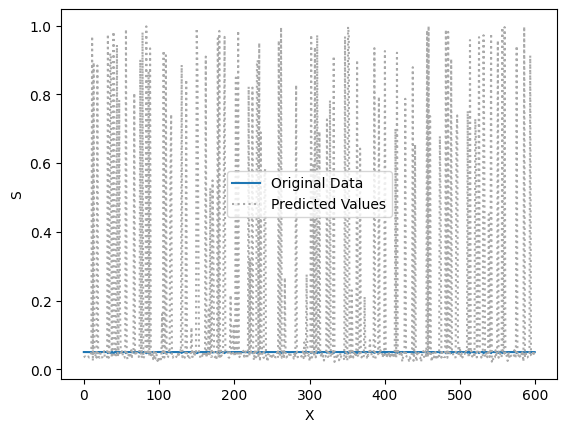

In [28]:
y_pred = MLP.forward(valid[:,0:-1])
plt.plot(y_pred.T)
plt.plot(valid[:,-1], ":", color="darkgrey", )
plt.legend(["Original Data", "Predicted Values"])
plt.xlabel("X"); plt.ylabel("S")
plt.show()

#### Worst

In [ ]:
n_neurons = [1,1,1,1]
n_activation = [sigmoid]*len(n_neurons)

MLP = perceptron(2,n_neurons, n_activation,0.2)
grad, grad_epoc, inst_ener_train, inst_aver_ener_train, inst_aver_ener_test = MLP.train_batch(train,50,3)

c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

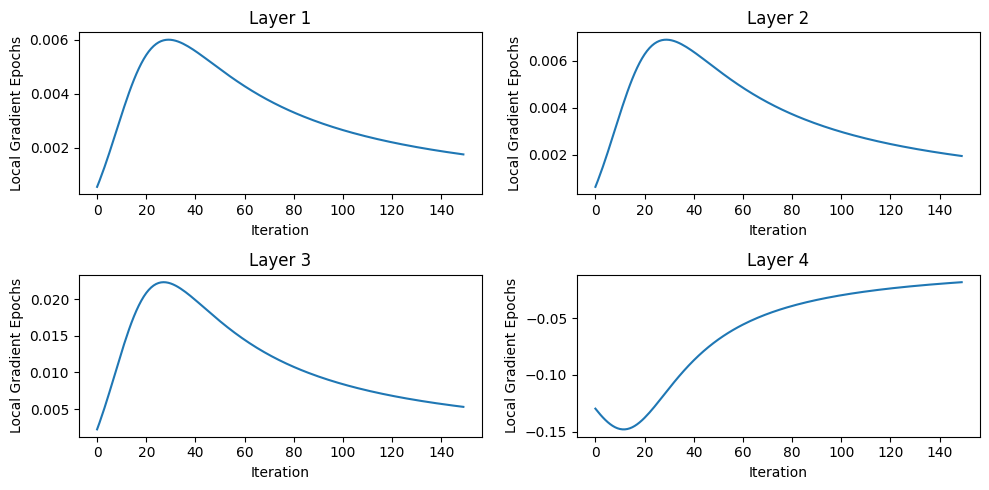

In [ ]:
df = pd.DataFrame(grad, columns=["Local Gradient Epochs"]*4)
titles = ["Layer 1", "Layer 2", "Layer 3",  "Layer 4"]
x_labels = ["Iteration"]*4
plot_subdivided_plane_with_data(df, titles, x_labels)

c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

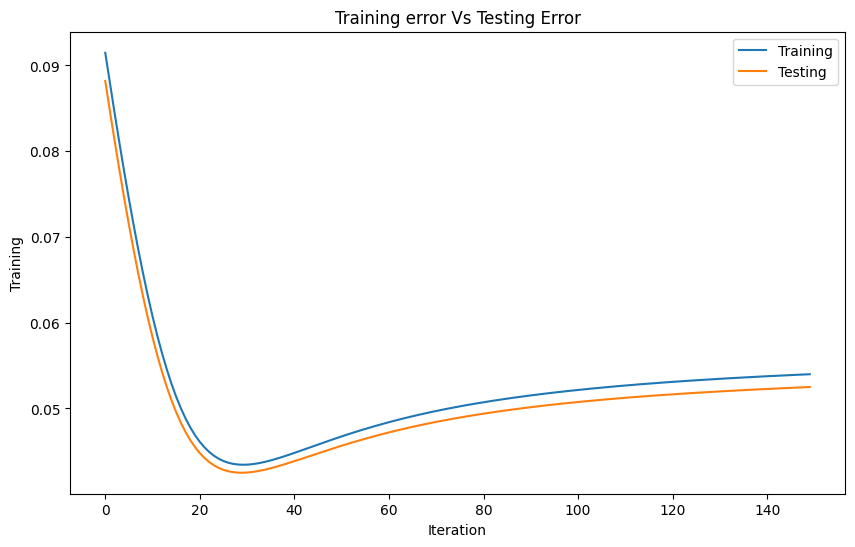

In [ ]:
df = pd.DataFrame({"Training": inst_ener_train,
                     "Testing": inst_aver_ener_test})

title = "Training error Vs Testing Error"
legends = []
x_label = "Iteration"

plot_multiple_graphs(df, title, x_label)

c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

Text(0.5, 0, 'Iterations')

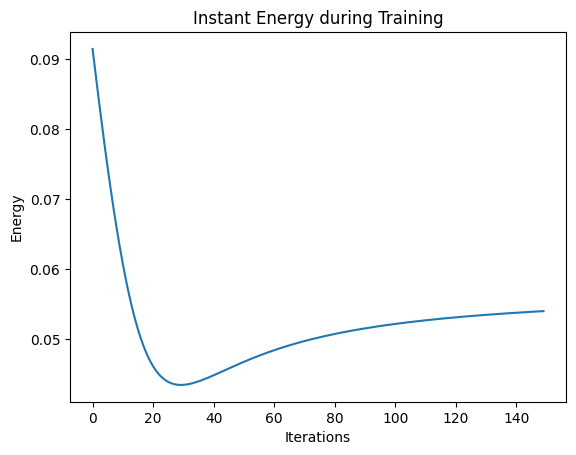

In [ ]:
plot = sns.lineplot(data=inst_ener_train)
plot.set_title("Instant Energy during Training")
plot.set_ylabel("Energy"); plot.set_xlabel("Iterations")

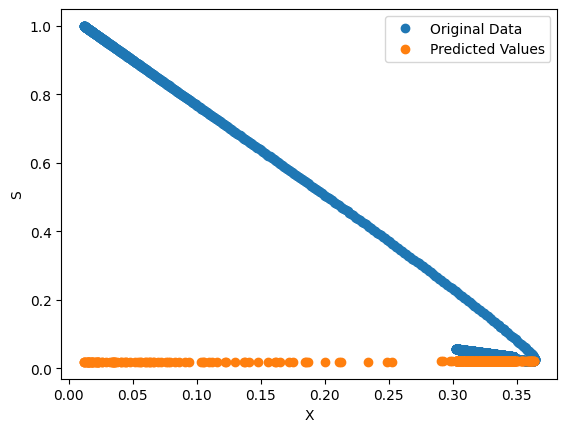

In [ ]:
y_pred = MLP.forward(valid[:,0:-1])
plt.plot(data[:,0],data[:,2],"o")
plt.plot(valid[:,0],y_pred.T,"o")
plt.legend(["Original Data", "Predicted Values"])
plt.xlabel("X"); plt.ylabel("S")
plt.show()

#### Mean

In [ ]:
n_neurons = [2,2,1]
n_activation = [sigmoid]*len(n_neurons)

MLP = perceptron(2,n_neurons, n_activation,0.9)
grad, grad_epoc, inst_ener_train, inst_aver_ener_train, inst_aver_ener_test = MLP.train_batch(train,50,3)

c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

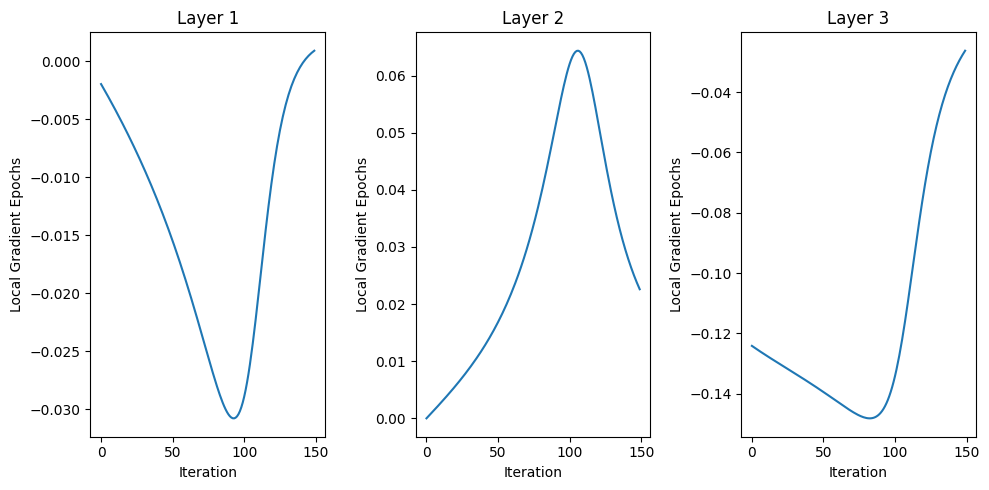

In [ ]:
df = pd.DataFrame(grad, columns=["Local Gradient Epochs"]*3)
titles = ["Layer 1", "Layer 2", "Layer 3"]
x_labels = ["Iteration"]*3
plot_subdivided_plane_with_data(df, titles, x_labels)

c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

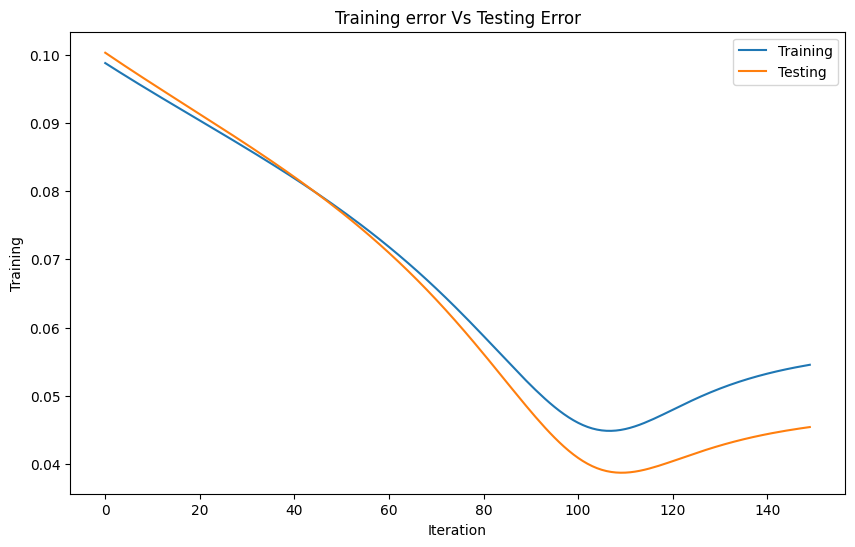

In [ ]:
df = pd.DataFrame({"Training": inst_ener_train,
                     "Testing": inst_aver_ener_test})

title = "Training error Vs Testing Error"
legends = []
x_label = "Iteration"

plot_multiple_graphs(df, title, x_label)

c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na opti

Text(0.5, 0, 'Iterations')

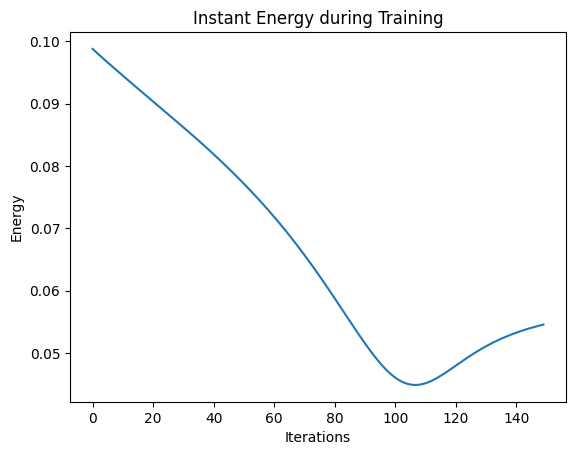

In [ ]:
plot = sns.lineplot(data=inst_ener_train)
plot.set_title("Instant Energy during Training")
plot.set_ylabel("Energy"); plot.set_xlabel("Iterations")

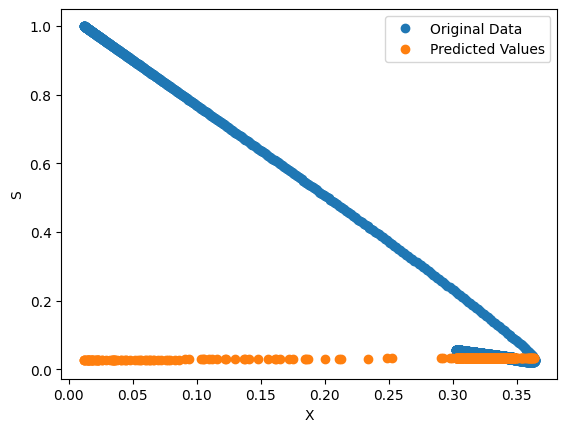

In [ ]:
y_pred = MLP.forward(valid[:,0:-1])
plt.plot(data[:,0],data[:,2],"o")
plt.plot(valid[:,0],y_pred.T,"o")
plt.legend(["Original Data", "Predicted Values"])
plt.xlabel("X"); plt.ylabel("S")
plt.show()

### Plotting the data

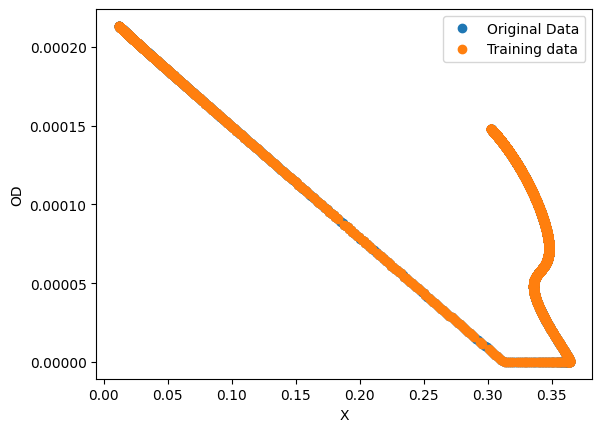

In [ ]:
plt.plot(data[:,0],data[:,1],"o")
plt.plot(train[:,0],train[:,1],"o")
plt.legend(["Original Data", "Training data"])
plt.xlabel("X"); plt.ylabel("OD")
plt.show()

Text(0, 0.5, 'OD')

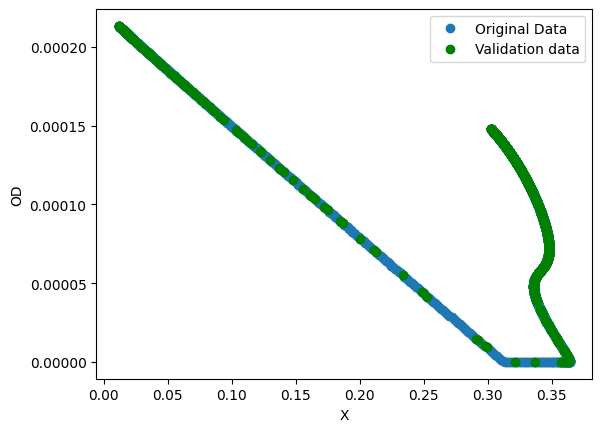

In [ ]:
plt.plot(data[:,0],data[:,1],"o")
plt.plot(valid[:,0],valid[:,1],"og")
plt.legend(["Original Data", "Validation data"])
plt.xlabel("X"); plt.ylabel("OD")

Histogram of all the architectures errors

c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Error')

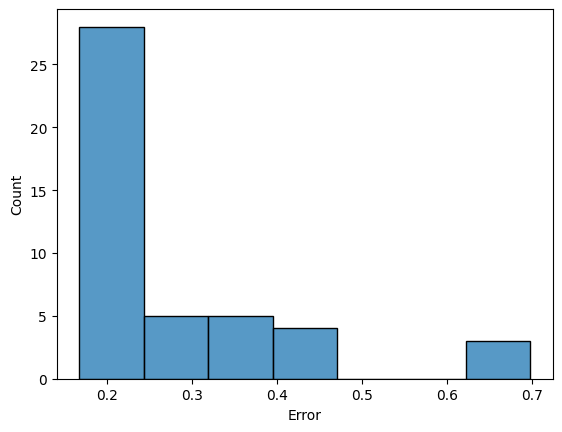

In [ ]:
plot = sns.histplot(epsilon)
plot.set_xlabel("Error")


c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\camil\Documents\EAFIT\SemestreIX\IA\MLP\.venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is depr

<Axes: ylabel='Count'>

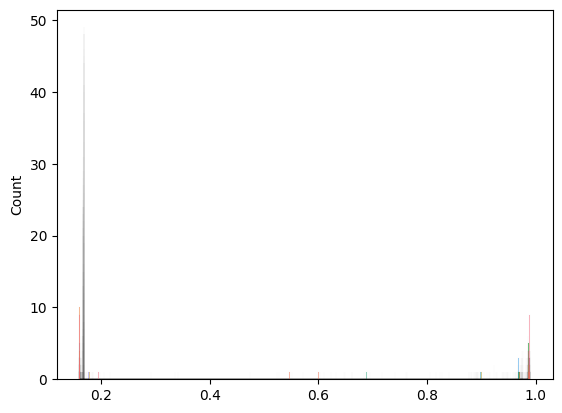

In [ ]:
a = np.array(epsilon_aver)
sns.histplot(a,legend=None)